In [1]:
import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
import numpy as np
from torch.utils.data import random_split
# import jax
import matplotlib.pyplot as plt
import os

In [2]:
qm9 = QM9(os.path.join(os.getcwd(), 'qm9_data'))

Extracting c:\Users\rotht\OneDrive\Studium\Master\Masterarbeit\Entwicklung\notebooks\Paper 1\qm9_data\raw\qm9.zip
Processing...
100%|██████████| 133885/133885 [02:09<00:00, 1031.39it/s]
Done!


In [3]:
for d in qm9:
    print (d)
    print(d.z)
    print(d.pos)
    break


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])
tensor([6, 1, 1, 1, 1])
tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])


In [4]:
# Now we will do some processing of the data to get into a more usable format. 
# Let’s convert to numpy arrays, remove the partial charges, and convert the elements into one-hot vectors.
def convert_record(d):
    # elements
    e = d.z #.numpy()
    # xyz position
    x = d.pos.numpy() # das hier ist Numpy aber wird später zu tensor (bei x2e)
    # target 
    y = d.y[0][7]

    # make ohc size larger
    # so use same node feature
    # shape later
    ohc = np.zeros((len(e), 16))
    ohc[np.arange(len(e)), e - 1] = 1
    ohc_tensor = torch.from_numpy(ohc)
    return (ohc_tensor, x), y

for d in qm9:
    (e, x), y = convert_record(d)
    print("Element one hots: \n", e)
    print("tensor size of elements: ", e.size()[0])
    print("Coordinates: \n", x)
    print("Label:", y)
    break

Element one hots: 
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor size of elements:  5
Coordinates: 
 [[-1.2700e-02  1.0858e+00  8.0000e-03]
 [ 2.2000e-03 -6.0000e-03  2.0000e-03]
 [ 1.0117e+00  1.4638e+00  3.0000e-04]
 [-5.4080e-01  1.4475e+00 -8.7660e-01]
 [-5.2380e-01  1.4379e+00  9.0640e-01]]
Label: tensor(-1101.4878)


In [5]:
dataset = torch.utils.data.random_split(qm9, [0.05,0.01,0.01,0.93])
training_set = dataset[0]
test_set = dataset[1]
validation_set = dataset[2]
# dataset[3] = all remaining data

In [6]:
ys = [convert_record(d)[1] for d in training_set]
train_ym = np.mean(ys)
train_ys = np.std(ys)
print("Mean = ", train_ym, "Std =", train_ys)


def transform_label(y):
    return (y - train_ym) / train_ys


def transform_prediction(y):
    return y * train_ys + train_ym

Mean =  -11193.296 Std = 1056.208


In [7]:
def x2e(x):
    """convert xyz coordinates to inverse pairwise distance"""
    r2 = np.sum((x - x[:, np.newaxis, :]) ** 2, axis=-1)
    e = np.where(r2 != 0, 1 / r2, 0.0)
    e = torch.from_numpy(e).double()
    return e

print(x2e(x))

tensor([[0.0000, 0.8387, 0.8387, 0.8388, 0.8387],
        [0.8387, 0.0000, 0.3145, 0.3145, 0.3145],
        [0.8387, 0.3145, 0.0000, 0.3145, 0.3145],
        [0.8388, 0.3145, 0.3145, 0.0000, 0.3145],
        [0.8387, 0.3145, 0.3145, 0.3145, 0.0000]], dtype=torch.float64)


C:\Users\rotht\AppData\Local\Temp/ipykernel_28132/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [8]:
def gnn_layer(nodes, edges, features, we, wb, wv, wu):

    leaky_relu = torch.nn.LeakyReLU(0.01)
    new_nodes_tensor = torch.repeat_interleave(nodes[None, :], nodes.size()[0], dim=0)
    input_tensor = wb + torch.matmul(new_nodes_tensor ,we) * torch.transpose(edges[:,None],1,2)
    ek = leaky_relu(input_tensor)

    # sum over neighbors to get N x features
    ebar = torch.sum(ek, 1)

    # dense layer for new nodes to get N x features
    new_nodes = leaky_relu(torch.matmul(ebar, wv) + nodes)

    # sum over nodes to get shape features
    global_node_features = torch.sum(new_nodes,0)    

    # dense layer for new features
    new_features = leaky_relu(torch.matmul(global_node_features, wu)) + features

    # just return features for ease of use
    return new_nodes, edges, new_features

In [9]:
graph_feature_len = 8
node_feature_len = 16
msg_feature_len = 16

# make our weights as tensors
def init_weights(g, n, m):

    we = torch.nn.Parameter(data=torch.Tensor(n,m).double(), requires_grad=True) 
    we.data.normal_(0,1e-1)
   
    wb = torch.nn.Parameter(data=torch.Tensor(m).double(), requires_grad=True) 
    wb.data.normal_(0,1e-1)

    wv = torch.nn.Parameter(data=torch.Tensor(m,n).double(), requires_grad=True) 
    wv.data.normal_(0,1e-1)

    wu = torch.nn.Parameter(data=torch.Tensor(n,g).double(), requires_grad=True) 
    wu.data.normal_(0,1e-1)
    
    return [we, wb, wv, wu]

# make a graph
nodes = e
edges = x2e(x)
features = np.zeros(graph_feature_len)
features = torch.from_numpy(features).double()

print("nodes: \n", nodes)
print("edges: \n", edges)
print("features: \n", features)

# eval
weights = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
out = gnn_layer(nodes, edges, features, *weights)

# print("weights: \n", weights)
print("input feautres: \n", features)
print("output features: \n", out[2])

nodes: 
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
edges: 
 tensor([[0.0000, 0.8387, 0.8387, 0.8388, 0.8387],
        [0.8387, 0.0000, 0.3145, 0.3145, 0.3145],
        [0.8387, 0.3145, 0.0000, 0.3145, 0.3145],
        [0.8388, 0.3145, 0.3145, 0.0000, 0.3145],
        [0.8387, 0.3145, 0.3145, 0.3145, 0.0000]], dtype=torch.float64)
features: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
input feautres: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
output features: 
 tensor([ 0.7096, -0.0040,  1.0613, -0.0149,  0.4481, -0.0014, -0.0047, -0.0079],
       dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\rotht\AppData\Local\Temp/ipykernel_28132/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [10]:
# get weights for both layers
w1 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
w2 = init_weights(graph_feature_len, node_feature_len, msg_feature_len) #! ausprobieren, kann sein, dass Variablen überschrieben werden!!!
[we1, wb1, wv1, wu1] = w1
[we2, wb2, wv2, wu2] = w2

w3 = torch.nn.Parameter(data=torch.Tensor(graph_feature_len).double(), requires_grad=True)
w3.data.normal_(0,1)

b = torch.nn.Parameter(data=torch.zeros(1).double(), requires_grad=True) # b wird mit einer Null initialisiert

class Model(nn.Module):
    # funktion für initialisierung hier einbauen

    def __init__(self, w1, w2, w3, b, graph_feature_len): # hier argumente für die layer
        # Gewichte werden hier initialisiert !!! Nicht übergeben
        # hier kann ich gnn_layer klasse aufrufen!
        # self.gnn_layer = # instanz initialisieren
        super(Model, self).__init__()
        self.w1= w1
        self.w2 = w2
        self.w3 = w3
        self.b = b
        self.graph_feature_len = graph_feature_len

    def gnn_layer(self, nodes, edges, features, we, wb, wv, wu): # separate Klasse die auch von nn.module erbt!
        """ Implementation of the GNN
        make nodes be N x N so we can just multiply directly
        ek is now shaped N x N x features """
        # ek = jax.nn.leaky_relu(web + jnp.repeat(nodes[jnp.newaxis, ...], nodes.shape[0], axis=0) @ we * edges[..., jnp.newaxis]
        leaky_relu = torch.nn.LeakyReLU(0.01)
        new_nodes_tensor = torch.repeat_interleave(nodes[None, :], nodes.size()[0], dim=0)
        input_tensor = wb + torch.matmul(new_nodes_tensor ,we) * torch.transpose(edges[:,None],1,2)
        ek = leaky_relu(input_tensor)
        # sum over neighbors to get N x features
        # ebar = jnp.sum(ek, axis=1)
        ebar = torch.sum(ek, 1)
        # dense layer for new nodes to get N x features
        # new_nodes = jax.nn.leaky_relu(ebar @ wv) + nodes
        new_nodes = leaky_relu(torch.matmul(ebar, wv) + nodes)
        # sum over nodes to get shape features
        # global_node_features = jnp.sum(new_nodes, axis=0)   
        global_node_features = torch.sum(new_nodes,0)    
        # dense layer for new features
        # new_features = jax.nn.leaky_relu(global_node_features @ wu) + features
        new_features = leaky_relu(torch.matmul(global_node_features, wu)) + features
        # just return features for ease of use
        return new_nodes, edges, new_features

    def forward(self, nodes, coords):
        f0 = torch.from_numpy(np.zeros(self.graph_feature_len)).double()
        e0 = x2e(coords)
        n0 = nodes
        n1, e1, f1 = gnn_layer(n0, e0, f0, *self.w1)
        n2, e2, f2 = gnn_layer(n1, e1, f1, *self.w2)
        yhat = torch.matmul(f2, self.w3) + self.b
        return yhat

def loss(nodes, coords, y, w1, w2, w3, b):
    return (Model(nodes, coords, w1, w2, w3, b) - y) ** 2

def loss1(nodes, coords, y, w1, w2, w3, b, graph_feature_len):
    model = Model(w1, w2, w3, b, graph_feature_len)
    model.eval()
    prediction = model(nodes, coords)
    return (model(nodes, coords) - y) ** 2

model = Model(w1, w2, w3, b, graph_feature_len)
model.eval()
print(model(nodes, x))

tensor([0.0009], dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\rotht\AppData\Local\Temp/ipykernel_28132/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [11]:
torch.save(model, os.path.join(os.getcwd(),'qm9_model.pt'))

In [12]:

optim = torch.optim.Adam([we1, wb1, wv1, wu1, we2, wb2, wv2, wu2, w3, b], lr=1e-3)
# arg1: über welche Parameter optimiert werden soll (Liste mit allen Parametern: *w1,*w2,w3, lr = eta (1e-3))

epochs = 16
eta = 1e-3
val_loss = [0.0 for _ in range(epochs)]
for epoch in range(epochs):
    for d in training_set:
        (e, x), y_raw = convert_record(d)
        y = transform_label(y_raw)
        # originally in jax:
        # grad = loss_grad(e, x, y, w1, w2, w3, b) # defined above in jax
        compute_loss = loss1(e, x, y, w1, w2, w3, b, graph_feature_len) # ursprünglich loss statt loss1
        
        optim.zero_grad() # vor backward gradienten null gesetzt, sonst Akkumulation vom vorherigen Schritt! (exploding/vanishing gradients)
        compute_loss.backward()
        optim.step()
        # * * *

    # compute validation loss
    for v in validation_set:
        (e, x), y_raw = convert_record(v)
        y = transform_label(y_raw)
        # convert SE to RMSE
    val_loss[epoch] += loss1(e, x, y, w1, w2, w3, b, graph_feature_len) # ursprünglich loss statt loss1 !
    val_loss[epoch] = torch.sqrt(val_loss[epoch] / 1000)
    eta *= 0.9

C:\Users\rotht\AppData\Local\Temp/ipykernel_28132/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


In [13]:
torch.save(model.state_dict(), 'qm9_model_weights.pt')

C:\Users\rotht\AppData\Local\Temp/ipykernel_28132/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


ys:  [tensor(-11949.2666), tensor(-11543.0127), tensor(-10329.9004), tensor(-10906.1367), tensor(-11510.7363), tensor(-10934.9785), tensor(-12927.3018), tensor(-11979.3145), tensor(-11511.4199), tensor(-10565.6895), tensor(-11674.7988), tensor(-11452.1631), tensor(-10566.2627), tensor(-10880.0811), tensor(-11747.5371), tensor(-10466.9912), tensor(-11948.6650), tensor(-10533.5605), tensor(-11342.6641), tensor(-11543.6045), tensor(-8922.0127), tensor(-9521.4932), tensor(-11946.0596), tensor(-11544.1982), tensor(-11509.7100), tensor(-11510.0352), tensor(-11343.4014), tensor(-10801.0283), tensor(-11844.8438), tensor(-9520.6670), tensor(-10532.7139), tensor(-11036.0527), tensor(-11979.9492), tensor(-10465.4629), tensor(-11844.7646), tensor(-11947.6826), tensor(-11881.5498), tensor(-10564.5674), tensor(-12318.8906), tensor(-10565.1904), tensor(-11576.7031), tensor(-10533.2822), tensor(-10605.7090), tensor(-11374.5713), tensor(-10499.9834), tensor(-10939.1025), tensor(-8896.3496), tensor(-109

Text(0, 0.5, 'Predicted Energy')

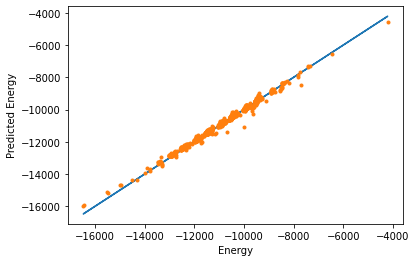

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


ys = []
yhats = []
for v in validation_set:
    (e, x), y = convert_record(v)
    ys.append(y)
    # yhat_raw = Model(e, x, w1, w2, w3, b)
    model = Model(w1, w2, w3, b, graph_feature_len)
    model.eval()
    yhat_raw = model(e, x)
    
    yhats.append(transform_prediction(yhat_raw))


yhats1 = []
for i in yhats:
    i = i.detach().numpy()
    yhats1.append(i)

print("ys: ", ys)
print("yhats: ", yhats)


mse = mean_squared_error(ys, yhats1)
print(f'MSE: {mse}')

rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(ys, yhats1)
print("R-squared (R2) Score:", r2)


plt.plot(ys, ys, "-")
plt.plot(ys, yhats1, ".")
plt.xlabel("Energy")
plt.ylabel("Predicted Energy")
#plt.title('Actual vs. Predicted Energy')
# plt.show()